In [9]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

In [10]:
lr = 0.1
n_epochs = 300
T = 10
N = 400

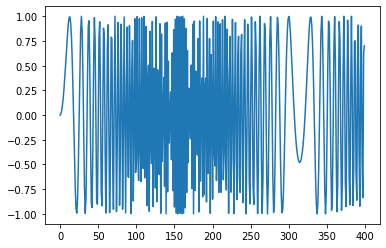

In [11]:
Y = np.sin((0.1*np.arange(N))**2) #+ np.random.rand(N) * 0.1

plt.plot(Y)

In [12]:
inputs = np.zeros((N-T, T, 1))
targets = np.zeros((N-T, 1))

for t in range(N-T):
    inputs[t] = Y[t:t+T].reshape(-1, 1)
    targets[t] = Y[t+T]

In [13]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
print(f'Device: {device}')

Device: cuda:0


In [14]:
train_inputs = torch.from_numpy(inputs[:N//2].astype(np.float32)).to(device)
train_targets = torch.from_numpy(targets[:N//2].astype(np.float32)).to(device)
test_inputs = torch.from_numpy(inputs[N//2:].astype(np.float32)).to(device)
test_targets =torch.from_numpy(targets[N//2:].astype(np.float32)).to(device)

In [15]:
class GatedRecurrentUnitRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GatedRecurrentUnitRNN, self).__init__()
        
        self.D = input_size
        self.M = hidden_size
        self.L = num_layers
        self.K = output_size
        
        self.rnn = nn.GRU(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True,
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, inputs):
        h0 = torch.zeros(self.L, inputs.size(0), self.M).to(device)
        
        outputs, _ = self.rnn(inputs, h0)
        outputs = self.fc(outputs[:, -1, :])
        
        return outputs

In [16]:
model = GatedRecurrentUnitRNN(1, 10, 1, 1)
model.to(device=device)

GatedRecurrentUnitRNN(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [18]:
def train_without_batch(model, criterion, optimizer, train_inputs, train_targets, test_inputs, test_targets, n_epochs=500):
    train_losses = []
    test_losses = []
    
    for it in range(n_epochs):
        
        optimizer.zero_grad()
        outputs = model(train_inputs)
        
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        test_losses.append(criterion(model(test_inputs), test_targets).item())
        
        print(f'Epoch {it+1}/{n_epochs}')
        
    return train_losses, test_losses

In [19]:
train_losses, test_losses = train_without_batch(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_inputs=train_inputs,
    test_inputs=test_inputs,
    train_targets=train_targets,
    test_targets=test_targets,
    n_epochs=n_epochs,
)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

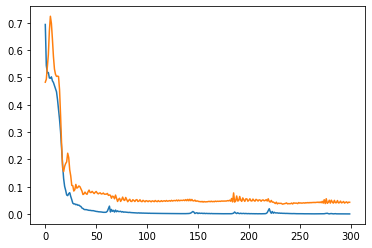

In [20]:
plt.plot(train_losses)
plt.plot(test_losses)

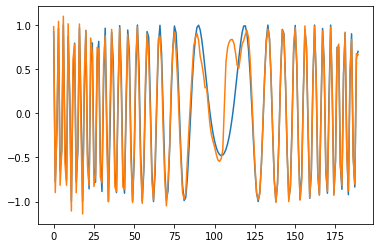

In [21]:
plt.plot(test_targets.cpu())
plt.plot(model(test_inputs).cpu().detach())

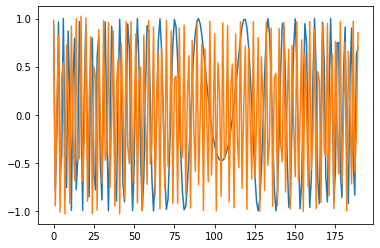

In [22]:
predictions = []
inputs = test_inputs[0]

while len(predictions) < len(test_targets):
    prediction = model(inputs.view(1, -1, 1))
    
    predictions.append(prediction.item())
    inputs = torch.concat((inputs[1:], prediction))
    
plt.plot(test_targets.cpu())
plt.plot(predictions)